# Task 1: Regression on Cancer Data

The objective is to predict the level of a specific cancer antigen using several clinical measures of patients. There are 97 records in total, with a training set indicated by a `T` in the `train` column and a test set by an `F`.


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load the data
data_path = r"C:\Users\ASHWITHA PN\Downloads\Task1_RegressionTask_CancerData.txt"
data = pd.read_csv(data_path, sep='\t')

In [3]:
# Provide a brief description of the data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               97 non-null     int64  
 1   logCancerVol        97 non-null     float64
 2   logCancerWeight     97 non-null     float64
 3   age                 97 non-null     int64  
 4   logBenighHP         97 non-null     float64
 5   svi                 97 non-null     int64  
 6   logCP               97 non-null     float64
 7   gleasonScore        97 non-null     int64  
 8   gleasonS45          97 non-null     int64  
 9   levelCancerAntigen  97 non-null     float64
 10  train               97 non-null     object 
dtypes: float64(5), int64(5), object(1)
memory usage: 8.5+ KB
None


## 2. Data Preprocessing

In [4]:
# Define the numerical features  to normalize
numerical_features = ['logCancerVol', 'logCancerWeight', 'age', 'logBenighHP', 'logCP']
# Initialize the Min-Max scaler
scaler = MinMaxScaler()
# Apply Min-Max scaling to the selected numerical features
data[numerical_features] = scaler.fit_transform(data[numerical_features])
print(data.head())

   index  logCancerVol  logCancerWeight       age  logBenighHP  svi  logCP  \
0      1      0.148460         0.164023  0.236842          0.0    0    0.0   
1      2      0.068269         0.392737  0.447368          0.0    0    0.0   
2      3      0.161810         0.131507  0.868421          0.0    0    0.0   
3      4      0.027689         0.377423  0.447368          0.0    0    0.0   
4      5      0.406048         0.439608  0.552632          0.0    0    0.0   

   gleasonScore  gleasonS45  levelCancerAntigen train  
0             6           0           -0.430783     T  
1             6           0           -0.162519     T  
2             7          20           -0.162519     T  
3             6           0           -0.162519     T  
4             6           0            0.371564     T  


In [5]:
#Feature Engineering (Interaction Terms)
data['age_logCancerVol_interaction'] = data['age'] * data['logCancerVol']
X = data.drop(['levelCancerAntigen', 'train'], axis=1)
y = data['levelCancerAntigen']
# Fit a random forest regressor to estimate feature importance
rf_model = RandomForestRegressor()
rf_model.fit(X, y)
feature_importances = rf_model.feature_importances_
# Select the top 5 features
top_features_indices = feature_importances.argsort()[-5:][::-1]
top_features = X.columns[top_features_indices]
print("Top 5 Features:")
print(top_features)

Top 5 Features:
Index(['index', 'logCancerVol', 'logCancerWeight', 'logCP', 'age'], dtype='object')


 The preprocessing steps applied in code serve the following purposes:

- **Normalization**: Ensures that numerical features are on a common scale for better model convergence.
- **Feature Engineering**: Creates a new feature to capture potential interactions between 'age' and 'logCancerVol.'
- **Feature Selection**: Identifies and selects the top 5 most important features for building predictive models.



## 3. Linear Regression Models

 ### Cross-Validation  for Model Selection:


In [6]:
# Split the data into training and test sets
train_data = data[data['train'] == 'T']
test_data = data[data['train'] == 'F']

X_train = train_data.drop(['levelCancerAntigen', 'train'], axis=1)
y_train = train_data['levelCancerAntigen']
X_test = test_data.drop(['levelCancerAntigen', 'train'], axis=1)
y_test = test_data['levelCancerAntigen']

In [7]:
# Initialize lists to store MSE values for different models
mse_least_squares = []
mse_ridge = []
mse_lasso = []

# Initialize lists to store complexity parameters
alphas = np.logspace(-6, 6, 13)

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


In [8]:
# Least Squares Regression
# Create a Linear Regression model
lr_model = LinearRegression()

# Train the model on your data
lr_model.fit(X_train, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_val)
mse_least_squares.append(mean_squared_error(y_val, lr_predictions))

In [9]:
# Ridge Regression with Cross-Validation for alpha selection
ridge_errors = []
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    ridge_predictions = ridge_model.predict(X_val)
    ridge_errors.append(mean_squared_error(y_val, ridge_predictions))

best_ridge_alpha = alphas[np.argmin(ridge_errors)]
best_ridge_model = Ridge(alpha=best_ridge_alpha)
best_ridge_model.fit(X_train, y_train)
ridge_predictions = best_ridge_model.predict(X_val)
mse_ridge.append(mean_squared_error(y_val, ridge_predictions))


In [10]:
# Lasso Regression with Cross-Validation for alpha selection
lasso_errors = []
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    lasso_predictions = lasso_model.predict(X_val)
    lasso_errors.append(mean_squared_error(y_val, lasso_predictions))

best_lasso_alpha = alphas[np.argmin(lasso_errors)]
best_lasso_model = Lasso(alpha=best_lasso_alpha)
best_lasso_model.fit(X_train, y_train)
lasso_predictions = best_lasso_model.predict(X_val)
mse_lasso.append(mean_squared_error(y_val, lasso_predictions))


In [11]:
# Calculate the average MSE across all folds for each model
avg_mse_least_squares = np.mean(mse_least_squares)
avg_mse_ridge = np.mean(mse_ridge)
avg_mse_lasso = np.mean(mse_lasso)

# Create a table to summarize results
results_df = pd.DataFrame({
    'Model': ['Least Squares', 'Ridge Regression', 'Lasso Regression'],
    'Average MSE': [avg_mse_least_squares, avg_mse_ridge, avg_mse_lasso]
})
# Display the results
print(results_df)

              Model  Average MSE
0     Least Squares     0.102997
1  Ridge Regression     0.101310
2  Lasso Regression     0.099028


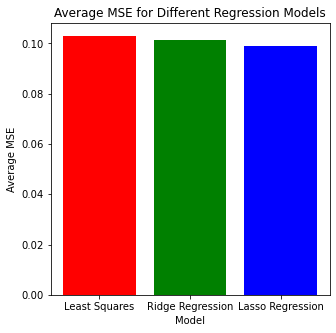

In [12]:
# Plot results
plt.figure(figsize=(5, 5))
plt.bar(results_df['Model'], results_df['Average MSE'], color=['red', 'green', 'blue'])
plt.title('Average MSE for Different Regression Models')
plt.xlabel('Model')
plt.ylabel('Average MSE')
plt.show()

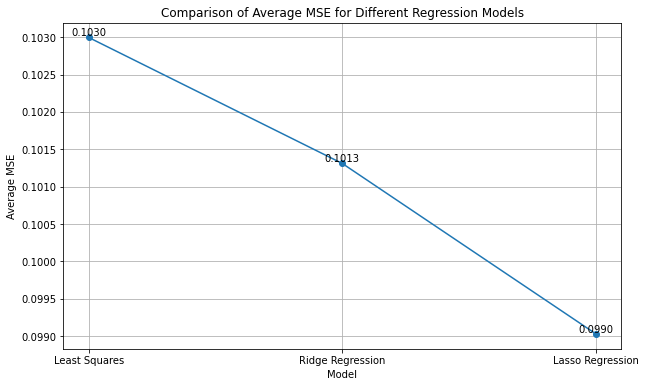

In [13]:
import matplotlib.pyplot as plt

# List of models and their corresponding MSE values
models = ['Least Squares', 'Ridge Regression', 'Lasso Regression']
mse_values = [avg_mse_least_squares, avg_mse_ridge, avg_mse_lasso]

# Create a line plot to compare MSE values
plt.figure(figsize=(10, 6))
plt.plot(models, mse_values, marker='o', linestyle='-')
plt.title('Comparison of Average MSE for Different Regression Models')
plt.xlabel('Model')
plt.ylabel('Average MSE')
plt.grid(True)

# Display the MSE values as text on the plot
for i, mse in enumerate(mse_values):
    plt.text(i, mse, f'{mse:.4f}', ha='center', va='bottom')

plt.show()


### 4. Infer Clinical Measures Influencing Cancer Antigen:

In [14]:
# Fit the Lasso Regression model on the entire dataset (you may have already done this)
lasso_model = Lasso(alpha=best_lasso_alpha)
lasso_model.fit(X_train, y_train)

# Get feature coefficients
coefficients = lasso_model.coef_
coeff_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})
coeff_df['Abs_Coefficient'] = abs(coeff_df['Coefficient'])
sorted_coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

# Select the top N features
top_features = sorted_coeff_df.head(5)

# Print the selected top features and their coefficients
print("Top Clinical Measures Influencing Cancer Antigen:")
print(top_features[['Feature', 'Coefficient']])

Top Clinical Measures Influencing Cancer Antigen:
                        Feature  Coefficient
1                  logCancerVol     0.500433
9  age_logCancerVol_interaction    -0.185190
5                           svi     0.123658
4                   logBenighHP     0.107916
6                         logCP     0.092666


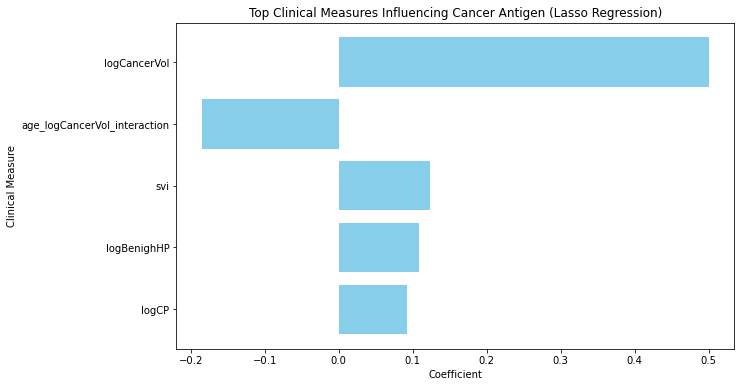

In [20]:
# Visualize the results with a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.title('Top Clinical Measures Influencing Cancer Antigen (Lasso Regression)')
plt.xlabel('Coefficient')
plt.ylabel('Clinical Measure')
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()


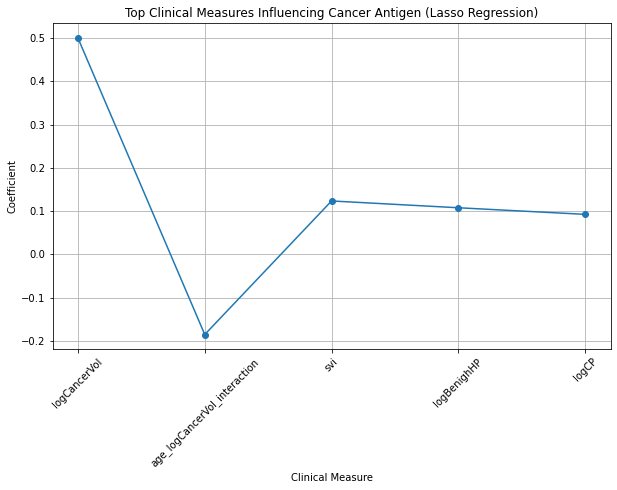

In [21]:
# Visualize the results with a line plot
plt.figure(figsize=(10, 6))
plt.plot(top_features['Feature'], top_features['Coefficient'], marker='o', linestyle='-')
plt.title('Top Clinical Measures Influencing Cancer Antigen (Lasso Regression)')
plt.xlabel('Clinical Measure')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
